<a href="https://colab.research.google.com/github/ernestomancebo/DeepLearningInPractice/blob/main/text_and_sequences/gru_bidirectional_rnn_weather_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Weather Forecast with Naïve Method, GRU and Bidirectional RNN

We're going to predict the weather using the Jena University dataset using a first naïve approach, later with a GRU and finaly contrasting those with a Bidirectional RNN.

##Getting the Dataset

In [2]:
# First we set up the data folder
!mkdir jena_climate
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip -d jena_climate
!rm  jena_climate_2009_2016.csv.zip 

--2021-01-22 14:27:14--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.1.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.1.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.8MB/s    in 0.9s    

2021-01-22 14:27:15 (13.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate/jena_climate_2009_2016.csv  
  inflating: jena_climate/__MACOSX/._jena_climate_2009_2016.csv  


Now we process the input file which contains all the data.

In [3]:
import os

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(f'Header: {header}')
print(f'No. Lines: {len(lines)}')

Header: ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
No. Lines: 420451


Moving from primitive array to NumPy array

In [4]:
import numpy as np

# Dimenssion: Elements, Features
float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

###Ploting the temperature in timeseries.

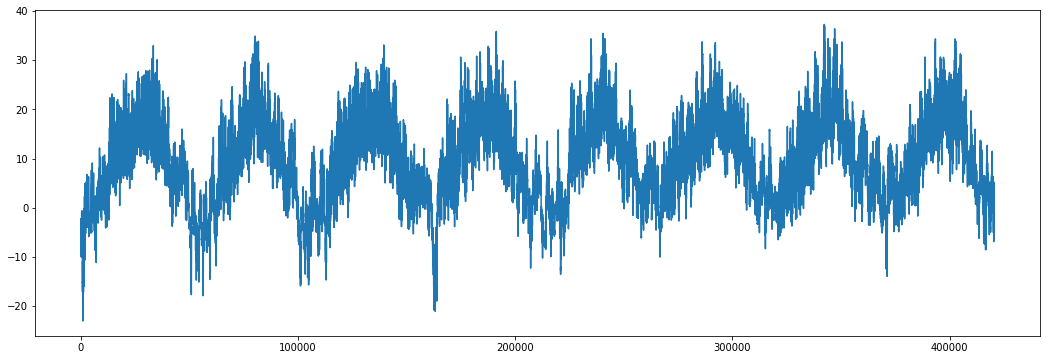

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.figure(figsize=(18, 6))
plt.plot(range(len(temp)), temp)

The dataset is composed by a 10-minutes frame metrics, meaning that per day there's `144` measures. To figure the first ten days we have to plot the first `1440` entries.

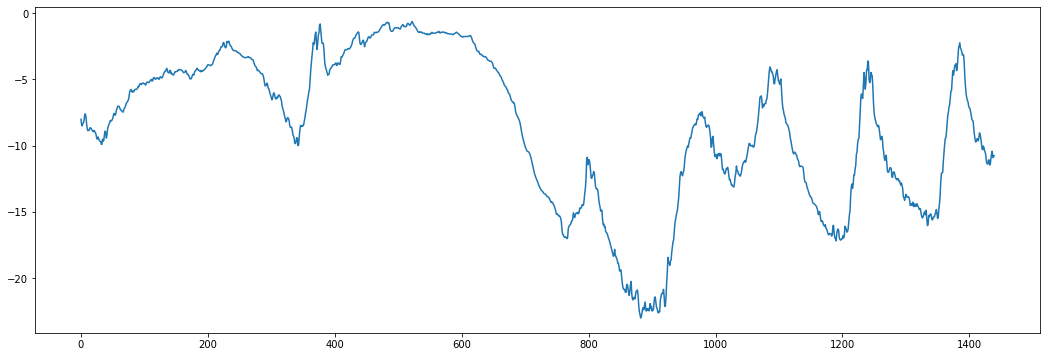

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(range(1440), temp[:1440])

##Preparing the Data

We're shaping the problem as follow:

Given a data going back as `lookback` timesteps (knowing that a timestep is 10 mint), and sampling every `steps` timesteps, we're predicting the temperature in `delay` timestep.

That said, some sample values are:

- `lookback = 720` -  Training back 5 days.
- `steps = 6` - Looking a 1 point per hour: 60/10 = 6.
- `delay = 144` -  The target is 24 hrs: 6 * 24 = 144.

We also need to shape the `float_data` into something that the neural network can digest, and also we need to scale down everything.

We're using the first 200,000 entries for training, so we're taking its mean and standard deviation.

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now we're setting a `generator` that yields a tuple of input data shaped as `(samples, targets)`.

In [6]:
def generator(data,lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1

  i = min_index + lookback

  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      # Defines the data slide indices
      idx = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[idx]
      targets[j] = data[rows[j] + delay][1]
    
    yield samples, targets

Now we define different generators for the splits we need

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200_000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200_001,
    max_index=300_000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300_001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

val_steps = (300_000 - 200_001 - lookback) // batch_size
test_steps = (len(float_data) - 300_001 - lookback) // batch_size

###Naïve Method

We're here implementing a naive implementation of forecasting based on historical data.

In [ ]:
def evaluate_naive_method():
  batch_maes = []

  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))

    batch_maes.append(mae)
  
  print(np.mean(batch_maes))

# evaluate_naive_method() # The output was ~0.29 (0.2896991739131649)

##A `Dense` approach

Let's see how a `Dense` regressor performs.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3360)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                107552    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%capture

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
plot_history(history)

##A `GRU` approach

Now we're using a GRU (Gated Recurrent Unit), which is another RNN variant but a bit lighter thant LSTM

In [ ]:
from keras.models import Sequential
from keras import layers 
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%capture

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

We have a better loss here, that's because of the nature of the data: sequential.

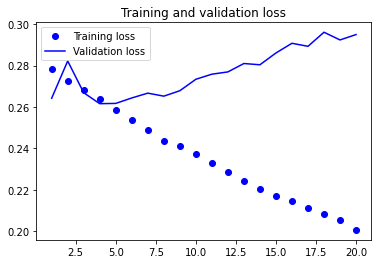

In [ ]:
plot_history(history)

##`GRU` with `Dropout`

Similar to ConvNet, we can implement a `Dropout` schema in RNN, but something to take in count is that the `Dropout` must be applied as a constant filter to every timestep instead a randomly generted filter at each step (this is the underneath of a `Dropout` in a RNN, we don't implement it here).

Also, something to note is that the `Dropout` is applied for the input sequence and also to the recurrent units, so the implementation of this with Keras is specifying those parameters.

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(
    32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4608      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Since the dropout reduces the information between cells/layers, more epochs are needed.
history = model.fit(
    train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps
)

Epoch 1/40
500/500 [==============================] - 134s 264ms/step - loss: 0.3739 - val_loss: 0.2798
Epoch 2/40
500/500 [==============================] - 132s 263ms/step - loss: 0.3100 - val_loss: 0.2836
Epoch 3/40
500/500 [==============================] - 133s 266ms/step - loss: 0.2998 - val_loss: 0.2779
Epoch 4/40
500/500 [==============================] - 137s 275ms/step - loss: 0.2924 - val_loss: 0.2776
Epoch 5/40
500/500 [==============================] - 134s 267ms/step - loss: 0.2906 - val_loss: 0.2722
Epoch 6/40
500/500 [==============================] - 134s 268ms/step - loss: 0.2880 - val_loss: 0.2729
Epoch 7/40
500/500 [==============================] - 134s 268ms/step - loss: 0.2815 - val_loss: 0.2681
Epoch 8/40
500/500 [==============================] - 133s 267ms/step - loss: 0.2791 - val_loss: 0.2721
Epoch 9/40
500/500 [==============================] - 134s 268ms/step - loss: 0.2784 - val_loss: 0.2722
Epoch 10/40
500/500 [==============================] - 134s 268m

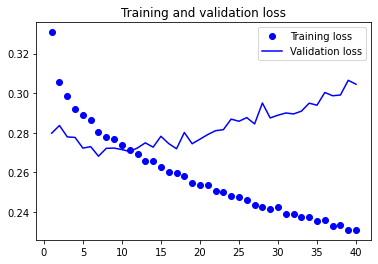

In [12]:
plot_history(history)

##Stacking RNN

Another approach to reduce overfiting on every DL model (besides Dropout) is adding more layers.

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(
    32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(
    64, dropout=0.1, recurrent_dropout=0.5, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 32)          4608      
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________


In [14]:
# %%capture

history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 366s 725ms/step - loss: 0.3405 - val_loss: 0.2776
Epoch 2/40
500/500 [==============================] - 362s 725ms/step - loss: 0.3035 - val_loss: 0.2728
Epoch 3/40
500/500 [==============================] - 362s 725ms/step - loss: 0.2973 - val_loss: 0.2805
Epoch 4/40
500/500 [==============================] - 361s 723ms/step - loss: 0.2895 - val_loss: 0.2730
Epoch 5/40
500/500 [==============================] - 361s 722ms/step - loss: 0.2842 - val_loss: 0.2737
Epoch 6/40
500/500 [==============================] - 361s 721ms/step - loss: 0.2776 - val_loss: 0.2755
Epoch 7/40
500/500 [==============================] - 362s 724ms/step - loss: 0.2697 - val_loss: 0.2736
Epoch 8/40
500/500 [==============================] - 361s 722ms/step - loss: 0.2669 - val_loss: 0.2848
Epoch 9/40
500/500 [==============================] - 361s 723ms/step - loss: 0.2600 - val_loss: 0.2829
Epoch 10/40
500/500 [==============================] - 363s 726m

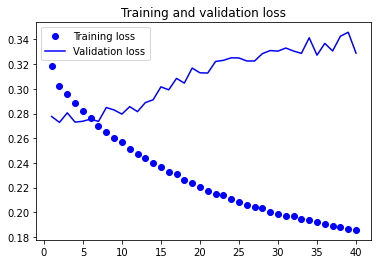

In [15]:
plot_history(history)

##Bidirectional `GRU`

A final approach is doing a bidirectiona RNN, which learns from chronological and reversed sequences. Order matters? let's see. 

In [21]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
  layers.GRU(32, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [22]:
# %%capture

history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 139s 270ms/step - loss: 0.3148 - val_loss: 0.2691
Epoch 2/40
500/500 [==============================] - 133s 267ms/step - loss: 0.2751 - val_loss: 0.2694
Epoch 3/40
500/500 [==============================] - 134s 269ms/step - loss: 0.2689 - val_loss: 0.2651
Epoch 4/40
500/500 [==============================] - 132s 265ms/step - loss: 0.2612 - val_loss: 0.2653
Epoch 5/40
500/500 [==============================] - 133s 266ms/step - loss: 0.2569 - val_loss: 0.2650
Epoch 6/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2501 - val_loss: 0.2712
Epoch 7/40
500/500 [==============================] - 138s 275ms/step - loss: 0.2444 - val_loss: 0.2733
Epoch 8/40
500/500 [==============================] - 137s 274ms/step - loss: 0.2384 - val_loss: 0.2762
Epoch 9/40
500/500 [==============================] - 137s 273ms/step - loss: 0.2329 - val_loss: 0.2818
Epoch 10/40
500/500 [==============================] - 137s 274m

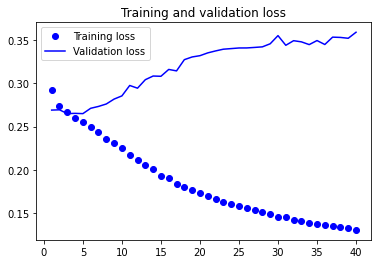

In [23]:
plot_history(history)